# Retrieval: High Resolution Emission Spectroscopy on WASP-77Ab


This tutorial covers how to run a retrieval with high resolution data using POSEIDON. We will reproduce the result from [Brogi and Line 2019](https://ui.adsabs.harvard.edu/abs/2021Natur.598..580L/abstract), validating our framework with the $\rm{H}_2\rm{O}$ and $\rm{CO}_2$ detection on WASP-77Ab.

To add another layer of complexity, we are not going to work with transmission spectroscopy but with *emission* spectroscopy. Thus, rather than having the planet crossing in front of the stellar disk, it will be observed approximately half-orbit later, when the dayside of the planet is in full view.
![Exoplanet Spectroscopy](../../_static/notebook_images/high_res_emis.png)
**NOTE:** At low spectral resolution (i.e. HST/WFC3) and in photometry (i.e. Spitzer IRAC), you are used to think to the planet's emission measured as the *drop in flux* during secondary eclipse. In HR spectroscopy, we can't accurately measure secondary eclipses because of the low SNR. We instead observe before or after secondary eclipse, i.e. when both the stellar and the planet spectrum are present. 

**RECALL:** What allows us to separate the two is the changing Doppler shift of the spectrum. This is explained by the figure below, where the telluric and stellar lines (stationary in wavelengths) are in the background and the planet's lines (Doppler-shifting) are in the foreground. The observed data is essentially a noise sum of the two, and our job to the extract the Doppler-shifting planet signals!

Since we do not need the secondary eclipse anymore, **HR emission spectroscopy can also be done on non-transiting planets**.
![Toy model of exoplanet spectroscopy at high spectral resolution](../../_static/notebook_images/high_res_emis_lines.png)

## Loading data
We start from a wavelength-aligned raw flux from the observation of our planet (WASP-77Ab). The data used in this tutorial should be under your data directory +"/IGRINS/data_raw.hdf5". We support analysis with combined multiple observations. To see how this could be done, see the transmission high-resolution retireval tutorial.

Your data should include
1. raw flux from the observation, This should be a 3D array: NOrders x NExposures x NPixels.
2. wavelength grid of your observations. This should be a 2D array: NOrders x Npixels.
3. orbital phase of each exposure. This should be a 1D array: NExposures.

Suppose this is the first time you use POSEIDON on this dataset. We will read the dataset in its raw form, processes it, and save it into POSEIDON compatibale format (.hdf5).

This example dataset can be downloaded from POSEIDON's reference data repoistory on Google Drive TODO.

In [20]:
from POSEIDON.high_res import (
    remove_outliers,
    blaze_correction,
    fit_uncertainties,
    prepare_high_res_data,
    read_hdf5,
)
import matplotlib.pyplot as plt
import numpy as np

data_dir = "/home/rwang/final_experiments/data/WASP-77Ab/"  # Special directory for this tutorial

name = "IGRINS"

data_raw = read_hdf5(
    data_dir + name + "/data_raw.hdf5"
)
flux = data_raw["flux"]
wl_grid = data_raw["wl_grid"]
phi = data_raw["phi"]
V_bary = data_raw["V_bary"]

In [19]:
data_raw.keys()

dict_keys(['V_bary', 'flux', 'phi', 'wl_grid'])

### Visualizing data
We start from a wavelength-aligned, preprocessed high resolution raw flux for our planet (WASP-77Ab). The data used in this tutorial should be under your directory +"/IGRINS/data_processed.hdf5". We support analysis with combined multiple observations. To see how this could be done, see the transmission high-resolution retireval tutorial.

In [ ]:
# from POSEIDON.high_res import read_high_res_data, fit_uncertainties
# import matplotlib.pyplot as plt
# import numpy as np
# import cmasher as cmr

# data_dir = "/home/rwang/final_experiments/data/WASP-77Ab/"  # Special directory for this tutorial

In [17]:
# data['IGRINS'].keys()

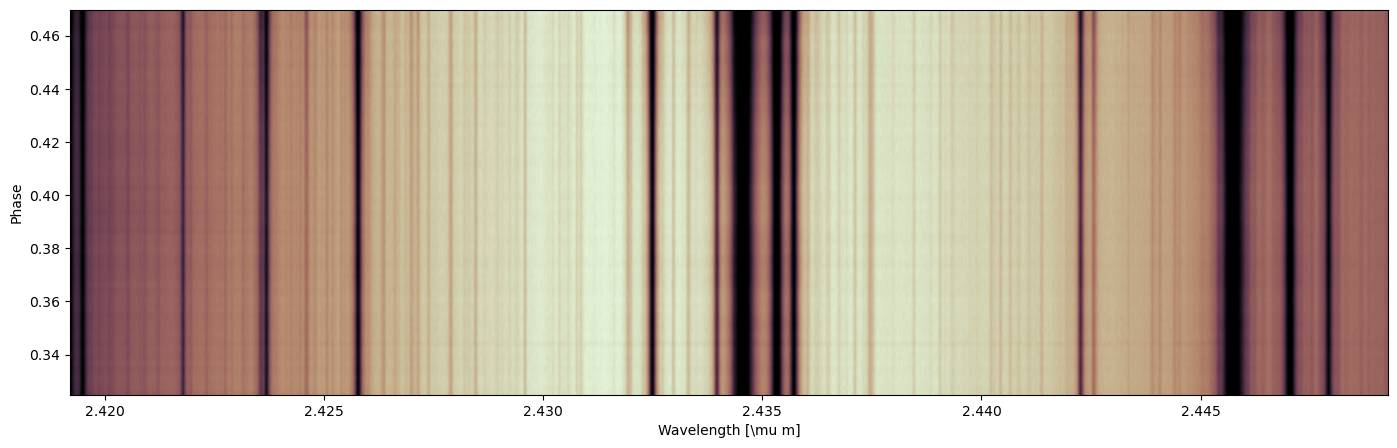

In [22]:
import cmasher as cmr
cmap = cmr.sepia
plt.figure(figsize=(17, 5))
plt.imshow(
    flux[0],
    aspect="auto",
    origin="lower",
    cmap=cmap,
    extent=[wl_grid[0][0], wl_grid[0][-1], phi[0], phi[-1]],
)
plt.ticklabel_format(useOffset=False)
plt.xlabel(r"Wavelength [\mu m]")
plt.ylabel("Phase")
plt.show()

In [23]:
# plt.figure(figsize=(17, 5))
# plt.imshow(
#     residualas[0],
#     aspect="auto",
#     origin="lower",
#     cmap=cmap,
#     extent=[wl_grid[0][0], wl_grid[0][-1], phi[0], phi[-1]],
# )
# plt.ticklabel_format(useOffset=False)
# plt.xlabel(r"Wavelength [\mu m]")
# plt.ylabel("Phase")

### Preparing Data From Raw Flux
The above data used for the tutorial is already processed with "prepare_high_res_data". When you perform your analysis on a new dataset, you need to call this function that will perform PCA or SYSREM to filter the data and save at given directory.
To use PCA instead of SYSREM, change 'sysrem' into 'pca'. No more changes are needed for other part of the code. Notice that PCA filtering does not acccount for time-wavelength dependent uncertainties and therefore we do not need to fit for the uncertainties.

In [24]:
from POSEIDON.high_res import prepare_high_res_data
uncertainties = fit_uncertainties(flux, initial_guess=[0.01, np.mean(flux)])
prepare_high_res_data(
    data_dir,
    name,
    "emission",
    "sysrem",
    flux,
    wl_grid,
    phi,
    uncertainties,
    None,
    V_bary,  # this data set is not barycentric corrected, therefore we provide the barycentric velocity
)

Fitting Poisson uncertainties with 5 components


/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/POSEIDON/high_res.py:59: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(a * flux[i] + b)


Creating processed data at /home/rwang/final_experiments/data/WASP-77Ab/IGRINS/data_processed.hdf5
Filtering out systematics using SYSREM with 15 iterations


## Setting up forward model
Below, we are setting up POSEIDON's forward model. This includes specifying the the properties of the star-planet system, which chemical species we want to include, the resolution at which we calculate the model, and the temperature-pressure profile of our model atmosphere.

Here we set the spectral resolution to be R=250,000. This is a tradeoff betweem speed (also RAM) and accuracy. Because our high-dispersion data usally has R ≥ 25,000, empirically we want our model to be 10 times more refined than the data such that when binned down to data resolution, it retains high accuracy.

For more advanced usage of POSEDION's emission forward model, see emission_scattering.ipynb.

Then, let's provide the wavelength grid and properties of the host star and your planet. The wavelength range should match the range of your data. This observation spans 1.3 microns to 2.6 microns.

In [25]:
from POSEIDON.core import (
    create_star,
    create_planet,
    make_atmosphere,
    read_opacities,
    compute_spectrum,
    define_model,
    wl_grid_constant_R,
)

from POSEIDON.constants import R_Sun, R_J, M_J

# ***** Wavelength grid *****#

wl_min = 1.3  # Minimum wavelength (um)
wl_max = 2.6  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# ***** Define stellar properties *****#

R_s = 0.91 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.48  # Stellar log surface gravity (log10(cm/s^2) by convention)

star = create_star(R_s, T_s, log_g_s, Met_s, wl=wl, stellar_grid="phoenix")

# ***** Define planet properties *****#

planet_name = "WASP-77Ab"  # Planet name used for plots, output files etc.

R_p = 1.21 * R_J  # Planetary radius (m)
M_p = 1.76 * M_J  # Mass of planet (kg)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

### Creating a Retrieval Model

Existing literature have shown detection of $\rm{H}_2\rm{O}$ and $\rm{C}\rm{O}_2$ in the atmosphere of WASP-77Ab.

So for a first attempt, we consider a model with $\rm{H}_2\rm{O}$ and $\rm{C}\rm{O}_2$, an isothermal temperature profile, and no clouds.

For additional parameters used in high resolution retrieval, we include: $log_{alpha}$ (the scaling parameter), $K_p$ (the Keplerian orbital velocity), $V_{sys}$ (the systematic velocity), and $W_{conv}$ (width of the gaussian convolution kernel used for line broadening). Additional parameters available are $\Delta \phi$ (offseting the ephemeris) and b (the scaling parameter for noise).

In [26]:
model_name = "Tutorial"  # Model name used for plots, output files etc.
bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl=wl, stellar_grid="phoenix")
param_species = ["H2O", "CO"]
high_res_params = ["K_p", "V_sys", "log_alpha", "W_conv"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_method="sysrem",
    high_res_params=high_res_params,
    reference_parameter="R_p_ref",
)

In [ ]:
# ***** Wavelength grid *****#

wl_min = 1.3  # Minimum wavelength (um)
wl_max = 2.6  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid
wl = wl_grid_constant_R(wl_min, wl_max, R)

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 400  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 50  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -5.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done


### Generating an emission spectrum and cross-correlating with data
To do so, you need to specify the atmosphere setting and provide values for your model parameters. We can the cross-correlate the spectrum we created with the processed data we obtained from running "prepare_high_res_data". We can plot the cross-correlating function as a function of $K_p$ and $V_{sys}$ and see the peak at the expected location.
If you want to run retrieval only, you can remove the cells from this section.

In [ ]:
# ***** Specify fixed atmospheric settings for retrieval *****#
# Specify the pressure grid of the atmosphere
P_min = 1.0e-5  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

log_species = [-4, -4]

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array(
    [0.2, 0.1, 0.17, -1.39, 1, 1500]
)  # a1, a2, log_P1, log_P2, log_P3, T_top
log_X_params = np.array([log_species])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, P_param_set=1e-5
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="direct_emission",
)

In [ ]:
from POSEIDON.high_res import cross_correlate,read_high_res_data

name = "IGRINS"
data = read_high_res_data(data_dir, names=[name])
data[name]["uncertainties"] = np.ones_like(uncertainties)
Kp_range = np.arange(0, 301, 1)
Vsys_range = np.arange(-100, 101, 1)
RV_range = np.arange(-100, 401, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        wl,
        spectrum,
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 18.98245072364807 seconds


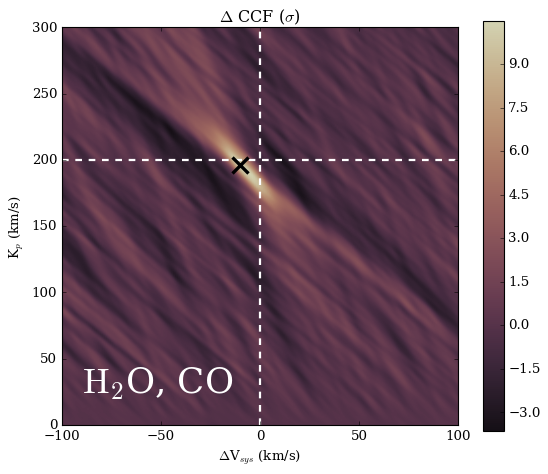

In [ ]:
from POSEIDON.high_res import plot_CCF_Kp_Vsys, plot_CCF_phase_RV

output_dir = f"POSEIDON_output/{planet_name}/plots/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    r"$\rm{H_2}$O, CO",
    200,
    Vsys=0,
    RM_mask_size=20,
    plot_label=True,
    file_path=output_dir + "CCF_Kp_Vsys.pdf",
    savefig=True,
    plot_slice=False,
    cmap=cmr.get_sub_cmap("cmr.sepia", 0.1, 0.9),
)

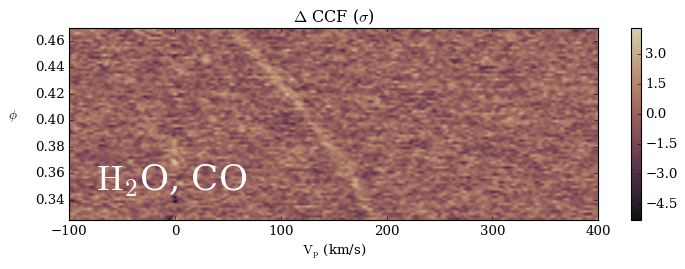

In [20]:
plot_CCF_phase_RV(
    phi,
    RV_range,
    np.mean(CCF_phase_RV_all, axis=0),
    r"$\rm{H_2}$O, CO",
    plot_label=True,
    save_path=output_dir + "WASP77_CCF_phase_H2O.pdf",
    cmap=cmr.get_sub_cmap("cmr.sepia", 0.1, 0.9),
)

### Setting Retrieval Priors

One of the most important aspects in any Bayesian analysis is deciding what priors to use for the free parameters. Specifying a prior has two steps: (i) choosing the type of probability distribution; and (ii) choosing the allowable range.

Most free parameters in atmospheric retrievals with POSEIDON use the following prior types:

- Uniform: you provide the minimum and maximum values for the parameter.
- Gaussian: you provide the mean and standard deviation for the parameter.

<div class="alert alert-info">

  **Note:**

  If you do not specify a prior type or range for a given parameter, POSEIDON will ascribe a default prior type (generally uniform) and a 'generous' range.

</div>


Your first retrieval is defined by three free parameters: (1) the isothermal atmospheric temperature; (2) the radius at the (fixed) reference pressure; (3) the log-mixing ratio of $\rm{Fe}$; and the four high resolution parameters. Since you don't have any *a priori* information on WASP-121b's atmosphere, you decide to use uniform priors for all the parameters. 

In [43]:
from POSEIDON.core import set_priors

# ***** Set priors for retrieval *****#

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types["T_ref"] = "uniform"
prior_types["R_p_ref"] = "uniform"
prior_types["log_X"] = "uniform"
prior_types["a1"] = "uniform"
prior_types["a2"] = "uniform"
prior_types["log_P1"] = "uniform"
prior_types["log_P2"] = "uniform"
prior_types["log_P3"] = "uniform"
prior_types["K_p"] = "uniform"
prior_types["V_sys"] = "uniform"
prior_types["log_alpha"] = "uniform"
prior_types["W_conv"] = "uniform"

# Initialise prior range dictionary
prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges["T_ref"] = [500, 2000]
prior_ranges["R_p_ref"] = [0.5 * R_p, 1.5 * R_p]
prior_ranges["log_X"] = [-15, 0]
prior_ranges["a1"] = [0, 1]
prior_ranges["a2"] = [0, 1]
prior_ranges["log_P1"] = [-5, 2]
prior_ranges["log_P2"] = [-5, 2]
prior_ranges["log_P3"] = [-2, 2]
prior_ranges["K_p"] = [150, 250]
prior_ranges["V_sys"] = [-50, 50]
prior_ranges["log_alpha"] = [-2, 2]
prior_ranges["W_conv"] = [0, 50]

# Create prior object for retrieval
priors = set_priors(planet, star, model, data, prior_types, prior_ranges)

### Run Retrieval

You are now ready to run your first high resolution atmospheric retrieval with SYSREM!

Here we will use the nested sampling algorithm MultiNest to explore the parameter space. The key input quantity you need to provide to MultiNest is called the *number of live points*, $N_{\rm{live}}$, which determines how finely the parameter space will be sampled (and hence the number of computed spectra). For exploratory retrievals, $N_{\rm{live}} = 400$ usually suffices. For publication-quality results, $N_{\rm{live}} = 2000$ is reasonable. 

<div class="alert alert-info">

  **Tip:**

  Retrievals run faster on multiple cores. When running the cells in this Jupyter notebook, only a single core will be used. You can run a multi-core retrieval on 24 cores by converting this Jupyter notebook into a python script, then calling mpirun on the .py file:

  ```
  mpirun -n 24 python -u YOUR_RETRIEVAL_SCRIPT.py
  ```
  
</div>


<div class="alert alert-info">

  **Important Note:**
  A high resolution forward model is computationally expensive (~1 second per model). With 400 live points, it took > $10^6$ evalutations for the model to converge. This retrieval could be finished with ~8 hours on 24 cores. You should consider convert the notebook into a '.py' file and run it with multiple cores in command line.
  
</div>

In [ ]:
from POSEIDON.retrieval import run_retrieval

run_retrieval(
    planet,
    star,
    model,
    opac,
    data,
    priors,
    wl,
    P,
    P_ref,
    R_p_ref=R_p,
    R=R,
    spectrum_type="emission",
    sampling_algorithm="MultiNest",
    N_live=400,
    verbose=True,
    N_output_samples=1000,
    resume=False,
    ev_tol=0.5,
)